## Parse API-files
Input: folder with gzip files
Output: saved csv

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [34]:
def parse_files(folder, upsample = True, keep = 120):
    
    hourly = pd.DataFrame()
    three_hourly = pd.DataFrame()
    for filename in os.listdir(folder):
        try:
            df = pd.read_csv(os.path.join(folder, filename), compression="gzip", parse_dates=["time"]).drop("Unnamed: 0", axis = 1)
            df = df.set_index("time")
            if upsample: df = df.resample("10T").bfill()
            df["collected"] = df.index[0] - timedelta(minutes=30)
            df = df.iloc[0:keep]
            if len(df.columns) == 5:
                hourly = hourly.append(df)
            else:
                three_hourly = three_hourly.append(df)
        except Exception as E:
            print("Failed to import:", filename)
            print("Error that occured:", E)


    return hourly, three_hourly
hourly, three_hourly = parse_files("./solcast")
hourly = hourly.sort_values(by=["collected", "time"])


Failed to import: .DS_Store
Error that occured: Not a gzipped file (b'\x00\x00')
Failed to import: Icon
Error that occured: No columns to parse from file


In [35]:
def get_predictions(df, timestamp):
    return df[df["collected"] == timestamp]

get_predictions(hourly, datetime(2021, 4, 6, hour = 10))

,temp,GHI,GHI90,GHI10,collected
time,,,,,
2021-04-06 10:30:00,4,591,591,557,2021-04-06 10:00:00
2021-04-06 10:40:00,4,601,610,538,2021-04-06 10:00:00
2021-04-06 10:50:00,4,601,610,538,2021-04-06 10:00:00
2021-04-06 11:00:00,4,601,610,538,2021-04-06 10:00:00
2021-04-06 11:10:00,5,598,620,466,2021-04-06 10:00:00
...,...,...,...,...,...
2021-04-07 05:40:00,1,38,84,4,2021-04-06 10:00:00
2021-04-07 05:50:00,1,38,84,4,2021-04-06 10:00:00
2021-04-07 06:00:00,1,38,84,4,2021-04-06 10:00:00


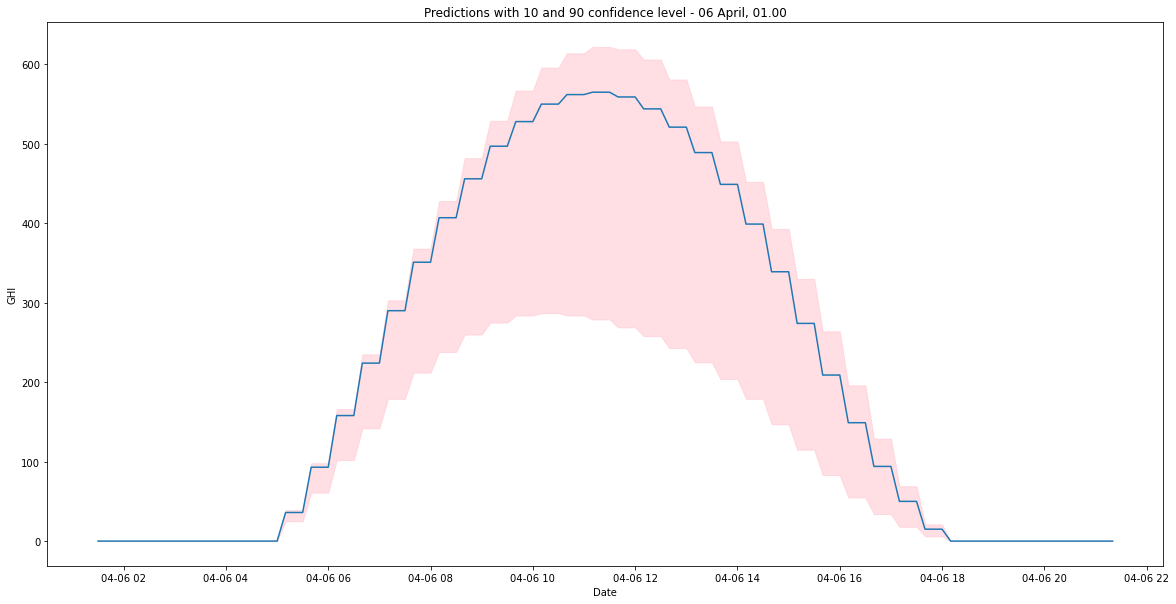

In [36]:
def plot_prediction(df):
    plt.figure(figsize = (20, 10))
    plt.plot(df.index, df["GHI"])
    plt.fill_between(df.index, df["GHI10"], df["GHI90"], alpha = 0.5, color = "pink")
    time = df.iloc[0]["collected"].strftime("%d %B, %H.%M")
    plt.title("Predictions with 10 and 90 confidence level - {}".format( time))
    
    plt.xlabel("Date")
    plt.ylabel("GHI")

plot_prediction(get_predictions(hourly, datetime(2021, 4, 6, hour = 1)))

In [39]:
hourly.to_csv("../src/data/solcast_cleaned.csv")